# Strategy #

Workflow for EDA and Feature Engineering:

Obtain domain knowledge <br>
↓ <br>
Make assumption <br>
↓ <br>
Test it (EDA) <br>
↓ <br>
Feature Engeneering <br>
 <br>


My strategy for reducing memory was: <br>
1. Change data type to the data type that uses small amount of memory Ex: int64 → int 32
This led to 28.6% reduction of memory in this data.
2. Delete used dataframe quickly  Ex: del df; gc.collect()

Time to load data: <br>
Data is large which means it takes time to load each time.
I used feather file instead of csv file to speed up the process.

This reduced loading time of 28.265625 seconds to 11.75 seconds. This is more than two times faster than loading data with csv file.
 <br>
 <br>
Model: <br>
Given <br>
1. Lack of samples for some attack id.
2. Lots of data.
3. Tabular data
4. Targets are not uniformly distributed.

I used LightGBM with stratified K-Fold (K=5).

Domain knowledge:  <br>
I mainly obtained domain knowledge from this website. 
https://securitytrails.com/blog/most-popular-types-dns-attacks
 <br>

Environment: <br>
Used CPU: Core i7

 <br>
Description of attacks from the perspective of data analysis alone: <br>

Attackid and Description: <br>
1 = This attack uses not many packets with medium sized data <br>
2 = This attack uses many packets with various sized data <br>
3 = This attack uses many packets with small sized data <br>
4 = This attack uses a few packets with medium sized data <br>
5 = This attack uses many packets with small sized data <br>


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 

import feather
import sys
import warnings
warnings.filterwarnings("ignore")

import gc


## Code for reducing memory and making feather files ##

In [3]:
# Reference: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

# def reduce_mem_usage(df, verbose=True):
#     numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
#     start_mem = df.memory_usage().sum() / 1024 ** 2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == "int":
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if (
#                     c_min > np.finfo(np.float16).min
#                     and c_max < np.finfo(np.float16).max
#                 ):
#                     df[col] = df[col].astype(np.float16)
#                 elif (
#                     c_min > np.finfo(np.float32).min
#                     and c_max < np.finfo(np.float32).max
#                 ):
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#     end_mem = df.memory_usage().sum() / 1024 ** 2
#     if verbose:
#         print(
#             "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
#                 end_mem, 100 * (start_mem - end_mem) / start_mem
#             )
#         )
#     return df


# q1 = pd.read_csv('./q1_total.csv',encoding="ISO-8859-1")
# reduce_mem_usage(q1)
# feather.write_dataframe(q1, './q1_total.feather')


In [4]:
q1 = feather.read_dataframe('./total_q1.feather')

q1.rename(columns={'No.':'id','Time':'time','Source':'source','Destination':'destination',
                   'Protocol':'protocol','Length':'length','Info':'info'},inplace=True)

q1.drop('packetid',axis=1,inplace=True)


res = q1[q1['info'].str.contains('response')]
sub = q1[~q1['info'].str.contains('response')]


train = sub[~sub['attackid'].isnull()]
test = sub[sub['attackid'].isnull()]

# EDA and Feature Engineering #

## Missing Values ##

First, check missing values.

In [5]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print('Missing data for training data: \n',missing_data)
print()

total = test.drop('attackid',axis=1).isnull().sum().sort_values(ascending=False)
percent = (test.drop('attackid',axis=1).isnull().sum()/test.drop('attackid',axis=1).isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print('Missing data for test data: \n ',missing_data)


Missing data for training data: 
              Total  Percent
attackid         0      0.0
info             0      0.0
length           0      0.0
protocol         0      0.0
destination      0      0.0
source           0      0.0
time             0      0.0
id               0      0.0

Missing data for test data: 
               Total  Percent
info             0      0.0
length           0      0.0
protocol         0      0.0
destination      0      0.0
source           0      0.0
time             0      0.0
id               0      0.0


There aren't any missing values.

## Number of different attacks for each ip address (destination) ##

Domain knowledge:  <br> It is less likely that the attackers will use two types of attacks with same ip address. <br>
Assumption:  <br> Same ip address always uses same attack. 

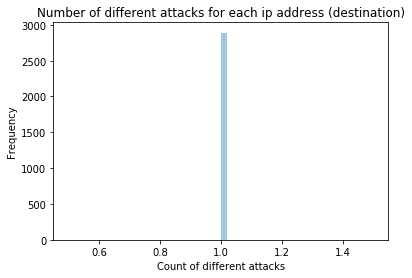

4909

In [6]:
dest = sub.dropna().groupby(['destination','attackid'],as_index=False)['id'].count()
sns.distplot(dest.groupby(['destination'],as_index=False)['attackid'].count()['attackid'].values,kde=False)

plt.title('Number of different attacks for each ip address (destination)')

plt.xlabel("Count of different attacks")
plt.ylabel("Frequency")

plt.savefig('./figure/count_dif_attacks')
plt.show()

del dest; gc.collect()

Result: <br> True. Each IP address uses only one type of attack. This means that if we alrady know attackid for one destination, other same destinations will have same types of attack.

## Number of different attacks for each ip address (source) ##

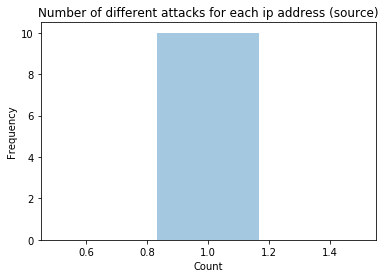

2145

In [7]:
source = sub.dropna().groupby(['source','attackid'],as_index=False)['id'].count()
sns.distplot(source.groupby(['source'],as_index=False)['attackid'].count()['attackid'].values,kde=False)

plt.xlabel("Count")
plt.ylabel("Frequency")

plt.title('Number of different attacks for each ip address (source)')

plt.xlabel("Count")
plt.ylabel("Frequency")

plt.show()

del source; gc.collect()

# Target Distribution #

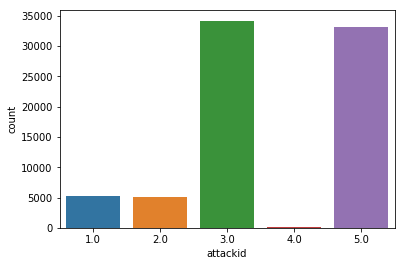

In [8]:
ax = sns.countplot(x="attackid", data=sub)

plt.savefig('./figure/target_distribution')

Result: Target is not uniformally distributed. I need to stratify targets when I apply cross validation.

## Pdf of length by target in submittion ##

Domain knowledge: Some attacks such as DoS attack sends many packets to shut down the website. Therefore, they just use small amount of data while other types of attack use relatively larger size of data. <br>
 <br>
Assumption:  Types of attack depends on size of packets transferred.

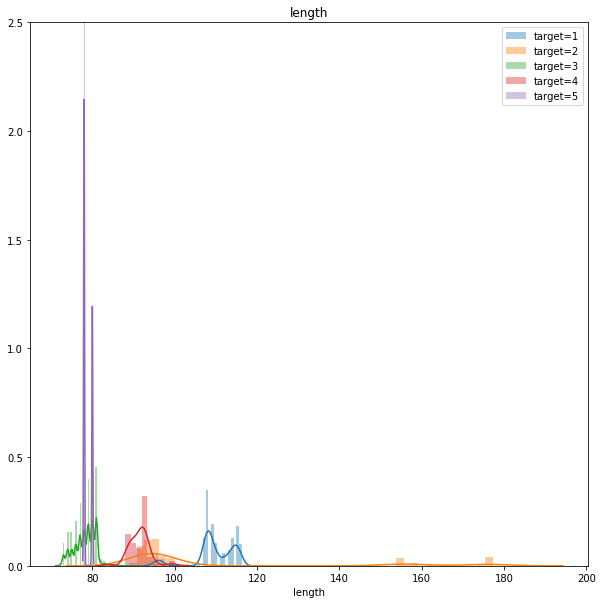

In [9]:
numerical = ['length']

attackids = [1,2,3,4,5]

for feature in numerical:
	fig, ax = plt.subplots(figsize=(10,10))
	plt.title(feature)
	
	for i in attackids:
		ax = sns.distplot(sub[sub['attackid']==i][feature],label='target=' + str(i))

	plt.legend() # Plot label in the graph
	plt.ylim(0,2.5)
	plt.savefig('./figure/size_packets.png')
	plt.show()


Result: True <br>
Attack id = 5 have many same small sized packets. <br>
Other attack ids also packets that have different size. <br>
 <br>
Thus, length of packet is strong predictor. <br>

## Count of packets

Domain knowledge: Some attacks such as DoS attack sends many packets to shut down the website. <br>
 <br>
Assumption:  Types of attack depends on count of packets transferred.

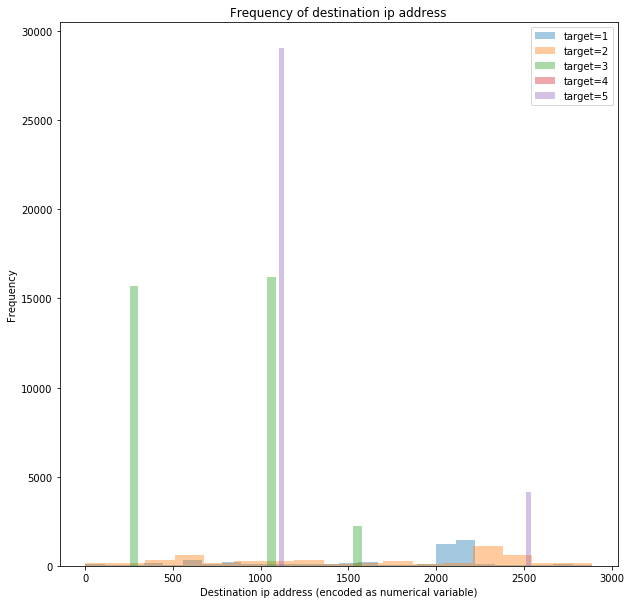

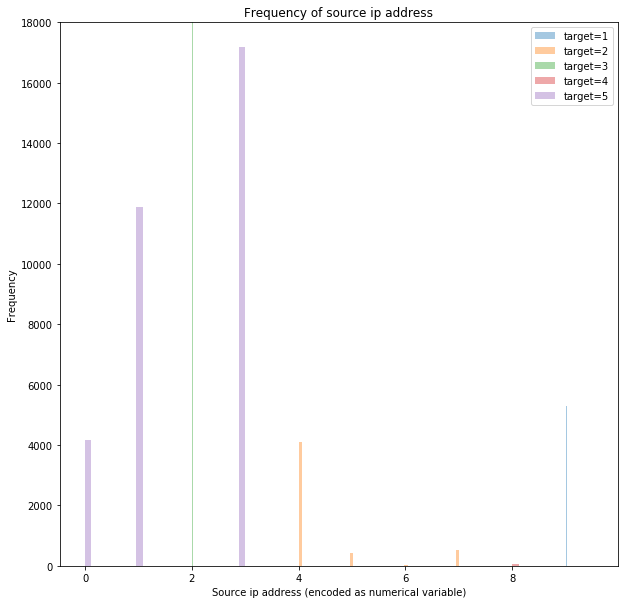

In [10]:
numerical = ['destination','source']

attackids = [1,2,3,4,5]

label_cols = ['source', 'destination']

# Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in label_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

for feature in numerical:
	fig, ax = plt.subplots(figsize=(10,10))
	plt.title(feature)
	
	for i in attackids:
		ax = sns.distplot(train[train['attackid']==i][feature],label='target=' + str(i),kde=False)

	if feature == 'destination':
		plt.title('Frequency of destination ip address')
		plt.xlabel("Destination ip address (encoded as numerical variable)")
		plt.ylabel("Frequency")
# 		plt.ylim(0,5000)
	else:
		plt.title('Frequency of source ip address')
		plt.xlabel("Source ip address (encoded as numerical variable)")
		plt.ylabel("Frequency")
		plt.ylim(0,18000)

	plt.legend() # Plot label in the graph
	plt.savefig('./figure/'+ str(feature) + '.png')
	plt.show()

Result: attackid = 5 and 2 use lots of packets. There is the clear trend for the number of packets sent for some types of attack.

## Email ##

Domain knowledge: Some attacks such as cache poisoning redirects to malicious website. <br>
 <br>
Assumption:  Types of attack depends on email.

In [11]:
temp = sub['info'].str.split(expand=True)
temp.columns = ['info_' + str(i) for i in temp.columns.values]

temp = temp[:1000]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     I just display first 5 rows of data for submission
    print(temp.groupby('info_4',as_index=False)['info_1'].count().head(5))


        info_4  info_1
0  0798.com.cn       2
1   0f3.com.cn       1
2  10d5.com.cn       2
3  1988.com.cn       2
4  1c8c.com.cn       1


Result: Email domain was all .com.cn. Also, ip addresses have information of emails. Therefore, email is not strong predictor of classifying attack id.

I only display 5 rows for submission, but the results showed all emails have .com.cn

## Common source or destination ip addresses between train and test data ##

Assumption: There are common source ip address or destination ip address between train and test data.

In [12]:
num = train[train['destination'].isin(test['destination'].values) | train['source'].isin(test['source'].values)].shape[0]

print(num/train.shape[0]*100,'%')

0.0 %


Training data covers 52% of destination or source ip address in test. This means that we could perfectly predict 52% of attack id in test because we know that same ip address is highly likely to have same type of attack id.

# Modeling #

## LightGBM ##

We will use LightGBM over other machine learning models for the following three reasons.
1. Lack of samples for some attack id.
2. Fast even though we have large amount of data.
3. Gradient boosting models have almost always have the highest accuracy over other models such as SVM and simple decision tree model on tabular data.

We will use stratified K-Fold because the target is not uniformally distributed. Also, we will let categorical variables as simple numerical variables because number of unique values are large and decision tree models can take care of numerical variables well. 

train_X:  (77803, 5)
train_y:  (77803,)

 fold 0
train_idx:  62241
val_idx:  15562

 ip address Overlap 65.72677174209926 % 

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[180]	training's multi_logloss: 2.79093e-08	valid_1's multi_logloss: 3.49986e-08

 fold 1
train_idx:  62241
val_idx:  15562

 ip address Overlap 91.78355103549107 % 

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[249]	training's multi_logloss: 2.91695e-08	valid_1's multi_logloss: 2.9278e-08

 fold 2
train_idx:  62243
val_idx:  15560

 ip address Overlap 91.78381504747522 % 

Training until validation scores don't improve for 500 rounds.
[1000]	training's multi_logloss: 2.52175e-08	valid_1's multi_logloss: 0.00453654
[2000]	training's multi_logloss: 2.51585e-08	valid_1's multi_logloss: 0.00453654
[3000]	training's multi_logloss: 2.51292e-08	valid_1's multi_logloss: 0.00453654
[4000]	training's multi_logloss: 2.5111

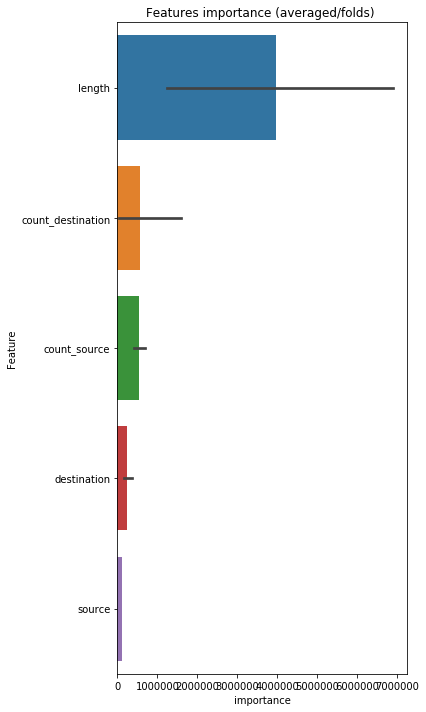

In [13]:
import lightgbm as lgb
from scipy import stats
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Fix seeds
from numpy.random import seed
seed(0)

np.set_printoptions(suppress=True)


# Load data
q1 = feather.read_dataframe('./total_q1.feather')

q1.rename(columns={'No.':'id','Time':'time','Source':'source','Destination':'destination',
                   'Protocol':'protocol','Length':'length','Info':'info'},inplace=True)

q1 = q1[~q1['info'].str.contains('response')]


train = q1[~q1['attackid'].isnull()]
test = q1[q1['attackid'].isnull()]


# Count encoding
count_features = ['source','destination']

for feature in count_features:
	train['count_' + feature] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
	test['count_' + feature] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))


train.drop(['time','info','protocol'],axis=1,inplace=True)
test.drop(['time','info','protocol'],axis=1,inplace=True)


label_cols = ['source', 'destination']

# Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in label_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

        
train_y = train['attackid']
train_X = train.drop(['attackid','packetid','id'], axis=1)

test_packetid = test['id']

test_X = test.drop(['attackid','packetid','id'], axis=1)

metric = 'multi_logloss'

params = {
		  'objective': 'multiclass',
		  "metric": metric,
		 }


folds = StratifiedKFold(n_splits=5)

# Out of fold predictions
oof = np.zeros(shape=(len(train_X),5))

# Predictions for test data
predictions = np.zeros(shape=(len(test_X),5))
feature_importance_df = pd.DataFrame()

print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

loss = list()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y)):
	strLog = "\n fold {}".format(fold_)
	print(strLog)

# 	Output the size of train and validation index
	print('train_idx: ',len(trn_idx))
	print('val_idx: ',len(val_idx))

	X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
	y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]


	# Check the percentage of ip address overlaps between training data and validation data
	num = X_tr[X_tr['destination'].isin(X_val['destination'].values) | X_tr['source'].isin(X_val['source'].values)].shape[0]
	print("\n ip address Overlap",num/X_tr.shape[0]*100,'% \n')
    
	model = lgb.LGBMClassifier(**params, n_estimators=5000, importance_type='gain', n_jobs=-1)

	model.fit(X_tr,
			  y_tr,
			  eval_set=[(X_tr,y_tr),(X_val, y_val)],
			  verbose=1000,
			  early_stopping_rounds=500)

	# Out of fold predictions
	oof[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)

	# Test prediction
	predictions += (model.predict_proba(test_X, num_iteration=model.best_iteration_)) / folds.n_splits

	loss.append(model.best_score_['valid_1'][metric])

	#Feature importance
	fold_importance_df = pd.DataFrame()
	fold_importance_df["Feature"] = train_X.columns.values
	fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
	fold_importance_df["fold"] = fold_ + 1
	feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print('Mean log loss = ',mean(loss))

oof = (np.argmax(oof,axis=1)+1).astype(int)

print()
print('Mean accuracy score = {}'.format(accuracy_score(train_y.values, oof)))


print('[' + str(len(train_X.columns.values))+']')
print(train_X.columns.values)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(6,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds) ')
plt.tight_layout()

plt.savefig('./figure/importance.png')
plt.show()


# Make submission file
test_X['attackid'] = (np.argmax(predictions,axis=1)+1).astype(int)
test_X['packetid'] = test_packetid

test_X[['packetid','attackid']].to_csv('./traffic.csv',header=True,index=False)



Result:  <br>
At the first fold, we could still predict types of attack with high accuracy even though we didn't know 34% of ip address of destination or source. This is because "length" variable is good predictor as hown in feature importance with "gain". Thus, our models could still predict test data well which training data doesn't have 48% of ip address of destination or source. 